In [13]:
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import scipy
from scipy import ndimage
from tensorflow.python.framework import ops
from handle_data import *
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [14]:
X_train, Y_train, X_test, Y_test, classes = load_data("signs")

y = 5


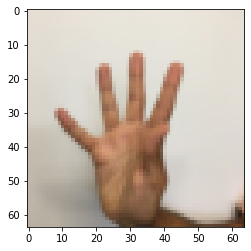

In [15]:
# Example of a picture
index = 12
plt.imshow(X_train[index])
print ("y = " + str(np.squeeze(Y_train[:, index])))

In [16]:
def onehot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [17]:
X_train = X_train / 255
X_test = X_test / 255
Y_train = onehot(Y_train, 6).T
Y_test = onehot(Y_test, 6).T

In [18]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))    
    return X, Y

In [19]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [20]:
def init_params():
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    params = {"W1": W1, "W2": W2}
    
    return params

In [21]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    params = init_params()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1[1,1,1] = \n" + str(params["W1"].eval()[1,1,1]))
    print("W1.shape: " + str(params["W1"].shape))
    print("\n")
    print("W2[1,1,1] = \n" + str(params["W2"].eval()[1,1,1]))
    print("W2.shape: " + str(params["W2"].shape))

AttributeError: module 'tensorflow.compat.v1' has no attribute 'contrib'

In [22]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding="SAME")
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding="SAME")
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding="SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding="SAME")
    F = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(F, 6, activation_fn=None)
    return Z3

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    params = init_params()
    Z3 = forward_propagation(X, params)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = \n" + str(a))

In [ ]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

In [23]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    params = init_params()
    Z3 = forward_propagation(X, params)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

AttributeError: module 'tensorflow.compat.v1' has no attribute 'contrib'

In [25]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    ops.reset_default_graph()
    seed = 3      
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    params = init_params()
    Z3 = forward_propagation(X, params)

    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss=cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run(fetches=[optimizer, cost],
                                         feed_dict={X: minibatch_X,
                                                    Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_preds = tf.equal(predict_op, tf.argmax(Y, 1))

        acc = tf.reduce_mean(tf.cast(correct_preds, "float"))
        print(acc)
        train_acc = acc.eval({X: X_train, Y: Y_train})
        test_acc = acc.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_acc)
        print("Test Accuracy:", test_acc)
                
        return train_acc, test_acc, params

In [ ]:
_, _, params = model(X_train, Y_train, X_test, Y_test)